In [169]:
!pip3 install tensorflow scikit-learn matplotlib pandas scikit-fuzzy networkx dash seaborn

In [170]:
!pip install seaborn

### Importing Libraries for Preprocessing

In [171]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

In [172]:
# Define paths to dataset files
base_path = 'Human Activity Recognition Smartphones/UCI HAR Dataset/'  # Replace this with your dataset path
x_train_path = base_path + 'train/X_train.txt'
y_train_path = base_path + 'train/y_train.txt'
x_test_path = base_path + 'test/X_test.txt'
y_test_path = base_path + 'test/y_test.txt'
features_path = base_path + 'features.txt'

# Load feature names
features = pd.read_csv(features_path, header=None, delim_whitespace=True)[1].values

# Load datasets
X_train = pd.read_csv(x_train_path, delim_whitespace=True, header=None)
y_train = pd.read_csv(y_train_path, delim_whitespace=True, header=None)
X_test = pd.read_csv(x_test_path, delim_whitespace=True, header=None)
y_test = pd.read_csv(y_test_path, delim_whitespace=True, header=None)

# Assign feature names to columns
if len(features) == X_train.shape[1]:
    X_train.columns = features
    X_test.columns = features
else:
    print("Feature names do not match dataset dimensions. Proceeding without column names.")

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train.values.ravel() - 1)  # Subtract 1 to make labels zero-indexed
y_test = to_categorical(y_test.values.ravel() - 1)

# Reshape data for CNN-LSTM (Sliding Window Segmentation)
def create_sliding_windows(data, labels, window_size, step):
    """
    Creates sliding windows for sequential models.

    :param data: Feature data
    :param labels: Corresponding labels
    :param window_size: Size of each sliding window
    :param step: Step size for sliding
    :return: Reshaped data and labels for CNN-LSTM
    """
    X, y = [], []
    for i in range(0, len(data) - window_size + 1, step):
        X.append(data[i:i + window_size])
        y.append(labels[i + window_size - 1])  # Label at the end of the window
    return np.array(X), np.array(y)

# Parameters for sliding windows
window_size = 128  # Typically used in HAR datasets
step_size = 64     # Overlapping step size

X_train, y_train = create_sliding_windows(X_train, y_train, window_size, step_size)
X_test, y_test = create_sliding_windows(X_test, y_test, window_size, step_size)

# Save the processed data for further use
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

# Display confirmation
print(f"Data preprocessing completed. Shapes: X_train={X_train.shape}, y_train={y_train.shape}, X_test={X_test.shape}, y_test={y_test.shape}")


/var/folders/kn/ctn4ccn10lb26_w9ssn6w1fm0000gn/T/ipykernel_42330/542511428.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  features = pd.read_csv(features_path, header=None, delim_whitespace=True)[1].values
/var/folders/kn/ctn4ccn10lb26_w9ssn6w1fm0000gn/T/ipykernel_42330/542511428.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv(x_train_path, delim_whitespace=True, header=None)
/var/folders/kn/ctn4ccn10lb26_w9ssn6w1fm0000gn/T/ipykernel_42330/542511428.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y_train = pd.read_csv(y_train_path, delim_whitespace=True, header=None)
/var/folders/kn/ctn4ccn10lb26_w9ssn6w1fm0000gn/T/ipykernel_42330/542511428.py:15: FutureWarnin

Data preprocessing completed. Shapes: X_train=(113, 128, 561), y_train=(113, 6), X_test=(45, 128, 561), y_test=(45, 6)


In [173]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten

# Define the CNN-LSTM model
model = Sequential([
    # Input layer
    Input(shape=(128, X_train.shape[2])),

    # CNN Layers
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # LSTM Layer
    LSTM(50, return_sequences=False),
    Dropout(0.3),

    # Fully Connected Layers
    Dense(100, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')  # Output layer (number of classes)
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_21 (Conv1D)              │ (None, 126, 64)        │       107,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_19 (MaxPooling1D) │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,482 (533.13 KB)

 Trainable params: 136,482 (533.13 KB)

 Non-trainable params: 0 (0.00 B)

In [174]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=40,  # Number of epochs (adjust based on your hardware and data size)
    batch_size=64,  # Adjust batch size as needed
    validation_split=0.2,  # Use 20% of training data for validation
    verbose=1
)


Epoch 1/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.1306 - loss: 1.8587 - val_accuracy: 0.3043 - val_loss: 1.6746
Epoch 2/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3264 - loss: 1.5978 - val_accuracy: 0.3478 - val_loss: 1.5361
Epoch 3/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4696 - loss: 1.4731 - val_accuracy: 0.3913 - val_loss: 1.4457
Epoch 4/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4369 - loss: 1.4154 - val_accuracy: 0.4348 - val_loss: 1.3427
Epoch 5/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4147 - loss: 1.3812 - val_accuracy: 0.4348 - val_loss: 1.2265
Epoch 6/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4978 - loss: 1.3175 - val_accuracy: 0.5217 - val_loss: 1.1324
Epoch 7/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6127 - loss: 1.1644 - val_accuracy: 0.6522 - val_loss: 1.0869
Epoch 8/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5749 - loss: 1.2203 - val_accuracy: 0.6522 - val_loss: 1.0720

In [175]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8590 - loss: 0.3609
Test Accuracy: 86.67%


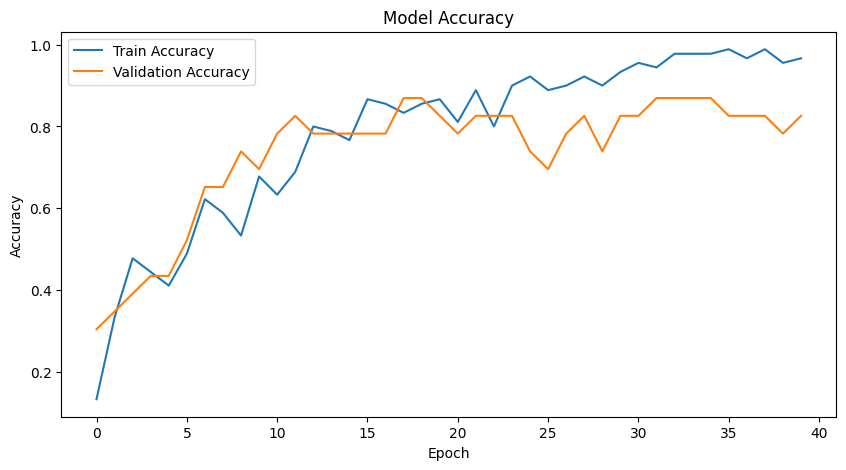

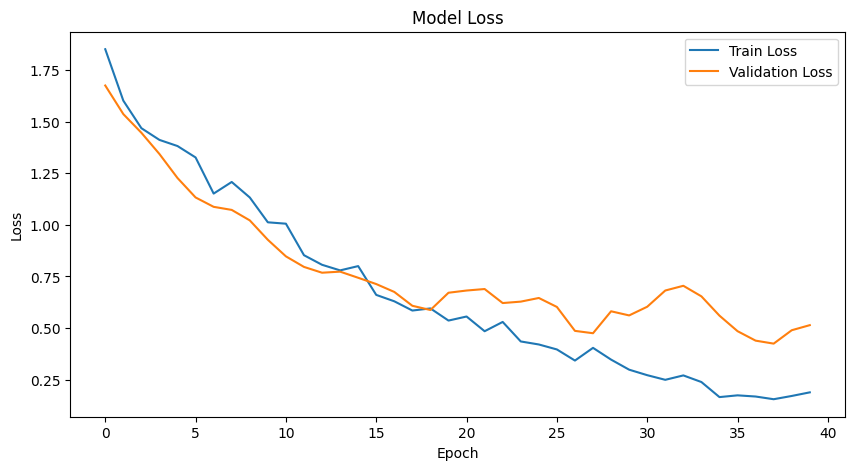

In [176]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [177]:
# Save the trained model
model.save('har_cnn_lstm_model.keras')
print("Model saved as har_cnn_lstm_model.keras")


Model saved as har_cnn_lstm_model.keras


In [178]:
# Make predictions on test data
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Calculate classification metrics
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.78      0.88         9
           2       0.60      0.75      0.67         4
           3       0.86      0.75      0.80         8
           4       0.80      1.00      0.89         8
           5       1.00      0.88      0.93         8

    accuracy                           0.87        45
   macro avg       0.86      0.86      0.85        45
weighted avg       0.88      0.87      0.87        45

Confusion Matrix:
[[8 0 0 0 0 0]
 [0 7 2 0 0 0]
 [1 0 3 0 0 0]
 [0 0 0 6 2 0]
 [0 0 0 0 8 0]
 [0 0 0 1 0 7]]


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - loss: 1.2993 - val_loss: 0.9728
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 1.1485 - val_loss: 0.7450
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.9593 - val_loss: 0.6909
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.8755 - val_loss: 0.6758
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.8331 - val_loss: 0.6697
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.8310 - val_loss: 0.6672
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.8253 - val_loss: 0.6665
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.8232 - val_loss: 0.6643
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.8225 - val_loss: 0.6628
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.8172 - val_loss: 0.6620
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.8162 - val_loss: 0.6613
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.8034 - val_loss: 0.6607

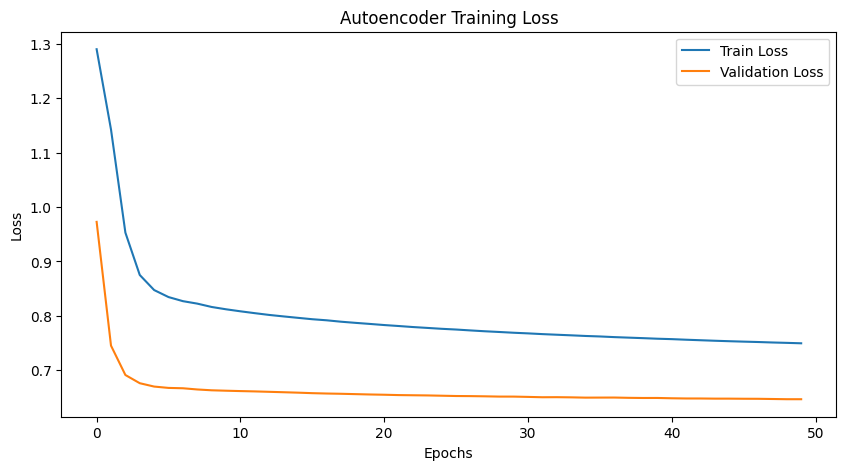

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Anomaly Threshold: 0.9218
Number of anomalies detected: 3


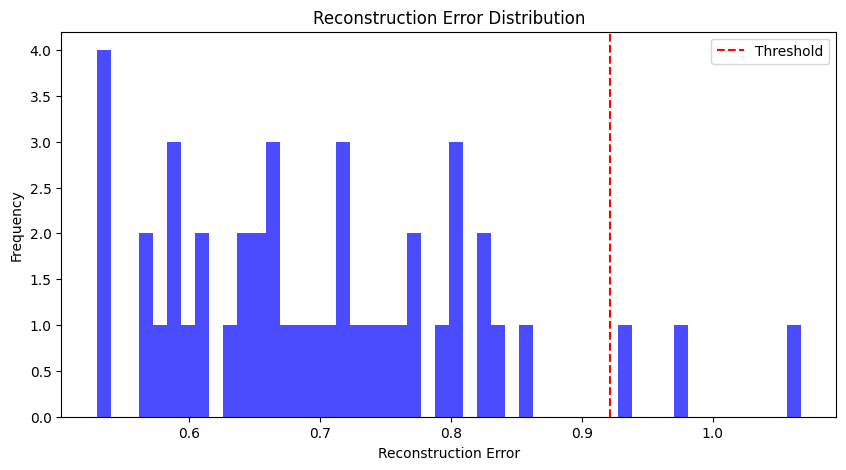

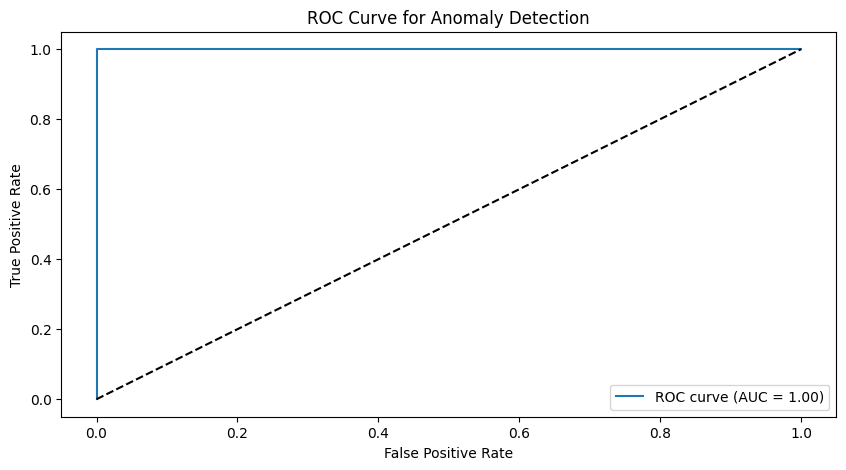

In [179]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Flatten the data for Autoencoder training (we don't need the temporal dimension for anomaly detection)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Define the Autoencoder architecture
input_dim = X_train_flat.shape[1]

input_layer = Input(shape=(input_dim,))
encoder = Dense(128, activation="relu")(input_layer)
encoder = Dense(64, activation="relu")(encoder)

decoder = Dense(128, activation="relu")(encoder)
decoder = Dense(input_dim, activation="sigmoid")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the Autoencoder
history = autoencoder.fit(
    X_train_flat, X_train_flat,
    epochs=50,  # Number of epochs
    batch_size=64,  # Adjust based on available memory
    validation_split=0.2,
    verbose=1
)

# Plot Autoencoder loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict on the test set
reconstructions = autoencoder.predict(X_test_flat)

# Calculate reconstruction errors
reconstruction_error = np.mean((X_test_flat - reconstructions) ** 2, axis=1)

# Define a threshold for anomalies
threshold = np.percentile(reconstruction_error, 95)  # Set at the 95th percentile of errors
print(f"Anomaly Threshold: {threshold:.4f}")

# Identify anomalies
anomalies = reconstruction_error > threshold
print(f"Number of anomalies detected: {np.sum(anomalies)}")

# Visualize reconstruction errors
plt.figure(figsize=(10, 5))
plt.hist(reconstruction_error, bins=50, color='blue', alpha=0.7)
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Evaluate anomaly detection using ROC-AUC
true_labels = np.array([0 if not a else 1 for a in anomalies])  # Assuming anomalies are 1, normal are 0
fpr, tpr, _ = roc_curve(true_labels, reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve for Anomaly Detection')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


/var/folders/kn/ctn4ccn10lb26_w9ssn6w1fm0000gn/T/ipykernel_42330/2515431317.py:23: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  features = pd.read_csv(
/var/folders/kn/ctn4ccn10lb26_w9ssn6w1fm0000gn/T/ipykernel_42330/2515431317.py:30: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv(f"{self.base_path}/train/X_train.txt", delim_whitespace=True, header=None)
/var/folders/kn/ctn4ccn10lb26_w9ssn6w1fm0000gn/T/ipykernel_42330/2515431317.py:31: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y_train = pd.read_csv(f"{self.base_path}/train/y_train.txt", delim_whitespace=True, header=None)
/var/folders/kn/ctn4ccn10lb26_w9ssn6w1fm0000gn/T/ipykernel_42330/2515431317.py:32: FutureWarning: The

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.1358 - loss: 1.8853 - val_accuracy: 0.3913 - val_loss: 1.5850
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3012 - loss: 1.6770 - val_accuracy: 0.3913 - val_loss: 1.4929
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3812 - loss: 1.6120 - val_accuracy: 0.3913 - val_loss: 1.4441
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3821 - loss: 1.5517 - val_accuracy: 0.4348 - val_loss: 1.3809
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4613 - loss: 1.4640 - val_accuracy: 0.7391 - val_loss: 1.3056
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5400 - loss: 1.3736 - val_accuracy: 0.6957 - val_loss: 1.2576
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5801 - loss: 1.2694 - val_accuracy: 0.6522 - val_loss: 1.2088
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5883 - loss: 1.2304 - val_accuracy: 0.6957 - val_loss: 1.1496

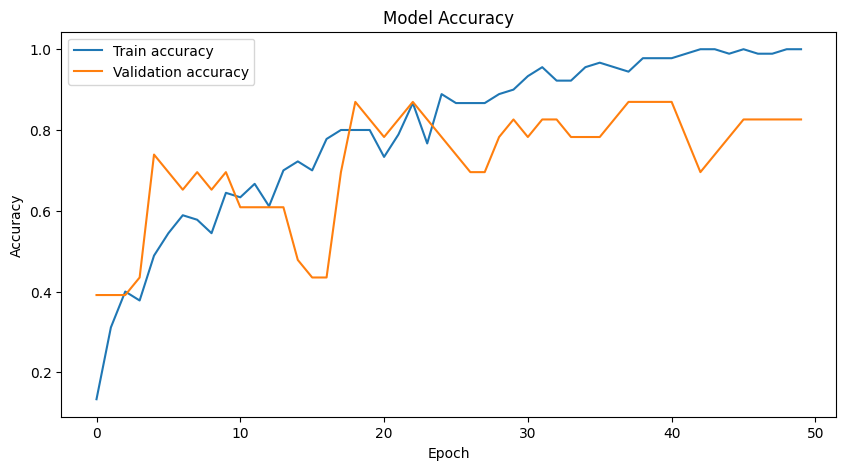

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - loss: 1.2900 - val_loss: 0.9794
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 1.1671 - val_loss: 0.7371
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.9399 - val_loss: 0.6823
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.8829 - val_loss: 0.6699
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.8397 - val_loss: 0.6693
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.8361 - val_loss: 0.6657
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.8370 - val_loss: 0.6636
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.8151 - val_loss: 0.6621
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.8176 - val_loss: 0.6607
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.8095 - val_loss: 0.6598
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.8138 - val_loss: 0.6593
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.8076 - val_loss: 0.658

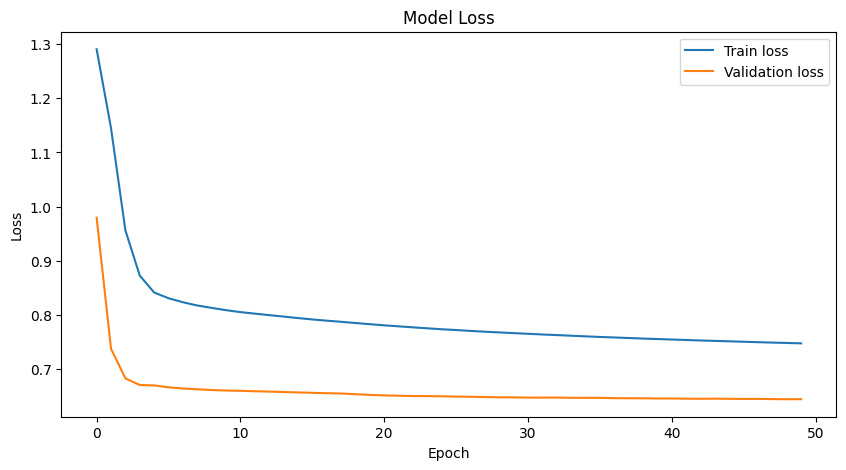

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


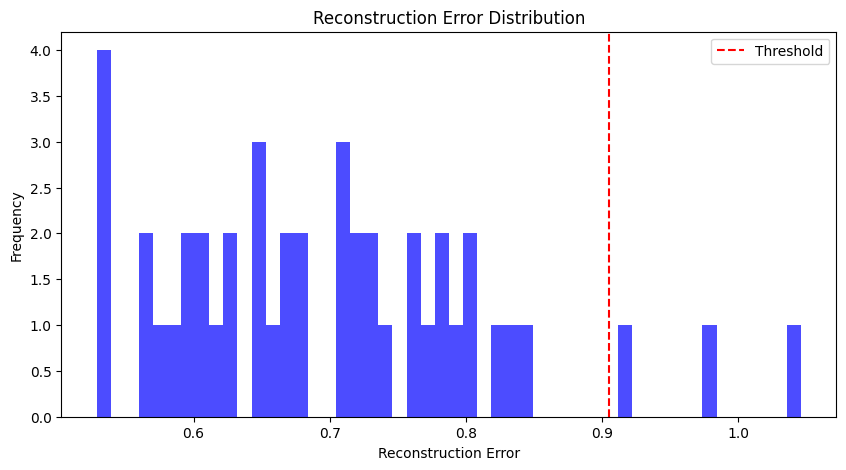

In [180]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, LSTM, Dense,
    Dropout, Flatten
)
from tensorflow.keras.utils import to_categorical

class HARDataProcessor:
    def __init__(self, base_path, window_size=128, step_size=64):
        self.base_path = base_path
        self.window_size = window_size
        self.step_size = step_size
        self.scaler = StandardScaler()

    def load_data(self):
        """Load and preprocess the HAR dataset."""
        # Load feature names
        features = pd.read_csv(
            f"{self.base_path}/features.txt",
            header=None,
            delim_whitespace=True
        )[1].values

        # Load datasets
        X_train = pd.read_csv(f"{self.base_path}/train/X_train.txt", delim_whitespace=True, header=None)
        y_train = pd.read_csv(f"{self.base_path}/train/y_train.txt", delim_whitespace=True, header=None)
        X_test = pd.read_csv(f"{self.base_path}/test/X_test.txt", delim_whitespace=True, header=None)
        y_test = pd.read_csv(f"{self.base_path}/test/y_test.txt", delim_whitespace=True, header=None)

        # Assign feature names
        if len(features) == X_train.shape[1]:
            X_train.columns = X_test.columns = features

        return X_train, y_train, X_test, y_test

    def preprocess_data(self, X_train, y_train, X_test, y_test):
        """Preprocess the data including normalization and windowing."""
        # Normalize features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Convert labels to one-hot encoding
        y_train_cat = to_categorical(y_train.values.ravel() - 1)
        y_test_cat = to_categorical(y_test.values.ravel() - 1)

        # Create sliding windows
        X_train_win, y_train_win = self._create_sliding_windows(
            X_train_scaled, y_train_cat, self.window_size, self.step_size
        )
        X_test_win, y_test_win = self._create_sliding_windows(
            X_test_scaled, y_test_cat, self.window_size, self.step_size
        )

        return X_train_win, y_train_win, X_test_win, y_test_win

    def _create_sliding_windows(self, data, labels, window_size, step):
        """Create sliding windows for sequential models."""
        X, y = [], []
        for i in range(0, len(data) - window_size + 1, step):
            X.append(data[i:i + window_size])
            y.append(labels[i + window_size - 1])
        return np.array(X), np.array(y)

class HARCNNLSTM:
    def __init__(self, input_shape, num_classes):
        self.model = self._build_model(input_shape, num_classes)

    def _build_model(self, input_shape, num_classes):
        """Build the CNN-LSTM model."""
        model = Sequential([
            Input(shape=input_shape),
            Conv1D(filters=64, kernel_size=3, activation='relu'),
            MaxPooling1D(pool_size=2),
            Dropout(0.3),
            LSTM(50, return_sequences=False),
            Dropout(0.3),
            Dense(100, activation='relu'),
            Dropout(0.3),
            Dense(num_classes, activation='softmax')
        ])

        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    def train(self, X_train, y_train, epochs=50, batch_size=64, validation_split=0.2):
        """Train the model and return training history."""
        return self.model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            verbose=1
        )

class HARAnomaryDetector:
    def __init__(self, input_dim):
        self.model = self._build_model(input_dim)

    def _build_model(self, input_dim):
        """Build the autoencoder model."""
        input_layer = Input(shape=(input_dim,))
        encoder = Dense(128, activation="relu")(input_layer)
        encoder = Dense(64, activation="relu")(encoder)
        decoder = Dense(128, activation="relu")(encoder)
        decoder = Dense(input_dim, activation="sigmoid")(decoder)

        model = Model(inputs=input_layer, outputs=decoder)
        model.compile(optimizer='adam', loss='mse')
        return model

    def train(self, X_train, epochs=50, batch_size=64, validation_split=0.2):
        """Train the autoencoder and return training history."""
        return self.model.fit(
            X_train, X_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            verbose=1
        )

    def detect_anomalies(self, X_test, threshold_percentile=95):
        """Detect anomalies in the test data."""
        reconstructions = self.model.predict(X_test)
        reconstruction_error = np.mean((X_test - reconstructions) ** 2, axis=1)
        threshold = np.percentile(reconstruction_error, threshold_percentile)
        anomalies = reconstruction_error > threshold
        return anomalies, reconstruction_error, threshold

def plot_training_history(history, metric='accuracy'):
    """Plot training history for given metric."""
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[metric], label=f'Train {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.title(f'Model {metric.capitalize()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()

def plot_anomaly_distribution(reconstruction_error, threshold):
    """Plot distribution of reconstruction errors."""
    plt.figure(figsize=(10, 5))
    plt.hist(reconstruction_error, bins=50, color='blue', alpha=0.7)
    plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
    plt.title('Reconstruction Error Distribution')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Usage example:
if __name__ == "__main__":
    # Initialize data processor
    processor = HARDataProcessor("Human Activity Recognition Smartphones/UCI HAR Dataset/")

    # Load and preprocess data
    X_train, y_train, X_test, y_test = processor.load_data()
    X_train_win, y_train_win, X_test_win, y_test_win = processor.preprocess_data(
        X_train, y_train, X_test, y_test
    )

    # Train CNN-LSTM model
    cnn_lstm = HARCNNLSTM(
        input_shape=(processor.window_size, X_train.shape[1]),
        num_classes=y_train_win.shape[1]
    )
    history = cnn_lstm.train(X_train_win, y_train_win)
    plot_training_history(history)

    # Train anomaly detector
    X_train_flat = X_train_win.reshape(X_train_win.shape[0], -1)
    X_test_flat = X_test_win.reshape(X_test_win.shape[0], -1)

    anomaly_detector = HARAnomaryDetector(X_train_flat.shape[1])
    history = anomaly_detector.train(X_train_flat)
    plot_training_history(history, 'loss')

    # Detect anomalies
    anomalies, reconstruction_error, threshold = anomaly_detector.detect_anomalies(X_test_flat)
    plot_anomaly_distribution(reconstruction_error, threshold)

In [181]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout

def build_har_model(input_shape, num_classes):
    """
    Build HAR model with proper input shape specification

    Args:
        input_shape: tuple (timesteps, features)
        num_classes: int, number of activity classes
    """
    model = Sequential([
        # Input layer with explicit shape
        Input(shape=input_shape),

        # CNN layers
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        # LSTM layer
        LSTM(50, return_sequences=False),
        Dropout(0.3),

        # Dense layers
        Dense(100, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Function to reshape data if needed
def reshape_data(X_train, X_test):
    """
    Reshape data to match the expected input shape
    """
    # Check if reshaping is needed
    if len(X_train.shape) != 3:
        # Assuming X_train is (samples, timesteps * features)
        n_timesteps = 128  # Your window size
        n_features = X_train.shape[1] // n_timesteps

        # Reshape to (samples, timesteps, features)
        X_train = X_train.reshape(X_train.shape[0], n_timesteps, n_features)
        X_test = X_test.reshape(X_test.shape[0], n_timesteps, n_features)

    return X_train, X_test

# Usage example:
def train_har_model(X_train, X_test, y_train, y_test):
    """
    Train the HAR model with proper data shapes
    """
    # Reshape data if needed
    X_train, X_test = reshape_data(X_train, X_test)

    # Get input shape from the reshaped data
    input_shape = (X_train.shape[1], X_train.shape[2])
    num_classes = y_train.shape[1]

    # Print shapes for verification
    print(f"Input shape: {input_shape}")
    print(f"Number of classes: {num_classes}")
    print(f"Training data shape: {X_train.shape}")
    print(f"Testing data shape: {X_test.shape}")

    # Build and compile model
    model = build_har_model(input_shape, num_classes)

    # Model summary
    model.summary()

    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=64,
        validation_split=0.2,
        verbose=1
    )

    return model, history

# Add data verification function
def verify_data_shapes(X_train, X_test, y_train, y_test):
    """
    Verify data shapes and types before training
    """
    print("\nData Shape Verification:")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")

    print("\nData Type Verification:")
    print(f"X_train dtype: {X_train.dtype}")
    print(f"y_train dtype: {y_train.dtype}")

    # Verify no NaN values
    print("\nNaN Value Check:")
    print(f"X_train NaN count: {np.isnan(X_train).sum()}")
    print(f"y_train NaN count: {np.isnan(y_train).sum()}")

    # Verify data range
    print("\nData Range Check:")
    print(f"X_train min: {X_train.min()}, max: {X_train.max()}")

    return all([
        len(X_train.shape) == 3,
        len(y_train.shape) == 2,
        not np.isnan(X_train).any(),
        not np.isnan(y_train).any()
    ])

# Example usage:

model, history = train_har_model(X_train, X_test, y_train, y_test)


AttributeError: 'DataFrame' object has no attribute 'reshape'

/var/folders/kn/ctn4ccn10lb26_w9ssn6w1fm0000gn/T/ipykernel_42330/2260063636.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.features = pd.read_csv(f"{self.base_path}/features.txt",
/var/folders/kn/ctn4ccn10lb26_w9ssn6w1fm0000gn/T/ipykernel_42330/2260063636.py:25: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.X_train = pd.read_csv(f"{self.base_path}/train/X_train.txt",
/var/folders/kn/ctn4ccn10lb26_w9ssn6w1fm0000gn/T/ipykernel_42330/2260063636.py:28: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.y_train = pd.read_csv(f"{self.base_path}/train/y_train.txt",
/var/folders/kn/ctn4ccn10lb26_w9ssn6w1fm0000gn/T/ipykernel_42330/2260063636.py:31: FutureWarning: The 'delim_whitespace' keyw

Epoch 1/62
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.1928 - loss: 1.8204 - val_accuracy: 0.2174 - val_loss: 1.5812
Epoch 2/62
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3086 - loss: 1.6331 - val_accuracy: 0.2174 - val_loss: 1.5955
Epoch 3/62
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5074 - loss: 1.4830 - val_accuracy: 0.1304 - val_loss: 1.5511
Epoch 4/62
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4622 - loss: 1.4577 - val_accuracy: 0.2174 - val_loss: 1.4654
Epoch 5/62
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5378 - loss: 1.3678 - val_accuracy: 0.1739 - val_loss: 1.3948
Epoch 6/62
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4495 - loss: 1.3658 - val_accuracy: 0.1739 - val_loss: 1.3310
Epoch 7/62
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4674 - loss: 1.3728 - val_accuracy: 0.2174 - val_loss: 1.2667
Epoch 8/62
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5979 - loss: 1.1837 - val_accuracy: 0.2174 - val_loss: 1.2127

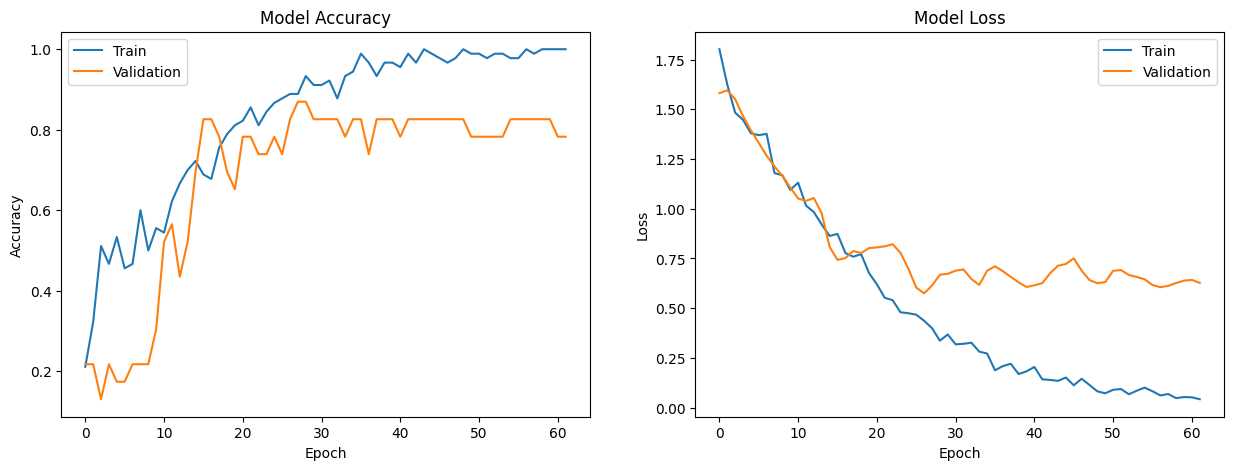

In [199]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

class HARDataProcessor:
    def __init__(self, base_path):
        self.base_path = base_path
        self.window_size = 128
        self.step_size = 64
        self.scaler = StandardScaler()

    def load_data(self):
        """Load and prepare the HAR dataset"""
        # Load feature names
        self.features = pd.read_csv(f"{self.base_path}/features.txt",
                                  header=None,
                                  delim_whitespace=True)[1].values

        # Load datasets
        self.X_train = pd.read_csv(f"{self.base_path}/train/X_train.txt",
                                 delim_whitespace=True,
                                 header=None)
        self.y_train = pd.read_csv(f"{self.base_path}/train/y_train.txt",
                                 delim_whitespace=True,
                                 header=None)
        self.X_test = pd.read_csv(f"{self.base_path}/test/X_test.txt",
                                delim_whitespace=True,
                                header=None)
        self.y_test = pd.read_csv(f"{self.base_path}/test/y_test.txt",
                                delim_whitespace=True,
                                header=None)

        return self

    def preprocess_features(self):
        """Preprocess features including normalization and window creation"""
        # Assign feature names
        if len(self.features) == self.X_train.shape[1]:
            self.X_train.columns = self.features
            self.X_test.columns = self.features

        # Normalize features
        self.X_train = self.scaler.fit_transform(self.X_train)
        self.X_test = self.scaler.transform(self.X_test)

        # Convert labels to one-hot encoding
        self.y_train = to_categorical(self.y_train.values.ravel() - 1)
        self.y_test = to_categorical(self.y_test.values.ravel() - 1)

        # Create sliding windows
        self.X_train, self.y_train = self._create_sliding_windows(
            self.X_train, self.y_train, self.window_size, self.step_size)
        self.X_test, self.y_test = self._create_sliding_windows(
            self.X_test, self.y_test, self.window_size, self.step_size)

        return self

    def _create_sliding_windows(self, data, labels, window_size, step):
        """Create sliding windows for sequential data"""
        X, y = [], []
        for i in range(0, len(data) - window_size + 1, step):
            X.append(data[i:i + window_size])
            y.append(labels[i + window_size - 1])
        return np.array(X), np.array(y)

    def save_processed_data(self, output_path):
        """Save processed data to files"""
        np.save(f"{output_path}/X_train.npy", self.X_train)
        np.save(f"{output_path}/X_test.npy", self.X_test)
        np.save(f"{output_path}/y_train.npy", self.y_train)
        np.save(f"{output_path}/y_test.npy", self.y_test)

class HARModel:
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self._build_model()

    def _build_model(self):
        """Build CNN-LSTM model"""
        model = Sequential([
            Input(shape=self.input_shape),
            Conv1D(filters=64, kernel_size=3, activation='relu'),
            MaxPooling1D(pool_size=2),
            Dropout(0.3),
            LSTM(50, return_sequences=False),
            Dropout(0.3),
            Dense(100, activation='relu'),
            Dropout(0.3),
            Dense(self.num_classes, activation='softmax')
        ])

        model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
        return model

    def train(self, X_train, y_train, epochs=62, batch_size=64, validation_split=0.2):
        """Train the model"""
        self.history = self.model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            verbose=1
        )
        return self

    def evaluate(self, X_test, y_test):
        """Evaluate model performance"""
        # Get predictions
        y_pred = self.model.predict(X_test)
        y_pred_classes = y_pred.argmax(axis=1)
        y_true = y_test.argmax(axis=1)

        # Print metrics
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred_classes))
        print("\nConfusion Matrix:")
        print(confusion_matrix(y_true, y_pred_classes))

        return self

    def plot_training_history(self):
        """Plot training history"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Accuracy plot
        ax1.plot(self.history.history['accuracy'], label='Train')
        ax1.plot(self.history.history['val_accuracy'], label='Validation')
        ax1.set_title('Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()

        # Loss plot
        ax2.plot(self.history.history['loss'], label='Train')
        ax2.plot(self.history.history['val_loss'], label='Validation')
        ax2.set_title('Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()

        plt.show()
        return self

# Usage Example
if __name__ == "__main__":
    # Initialize and process data
    processor = HARDataProcessor(base_path='Human Activity Recognition Smartphones/UCI HAR Dataset')
    processor.load_data().preprocess_features()

    # Create and train model
    model = HARModel(
        input_shape=(processor.window_size, processor.X_train.shape[2]),
        num_classes=processor.y_train.shape[1]
    )

    # Train and evaluate
    model.train(processor.X_train, processor.y_train)
    model.evaluate(processor.X_test, processor.y_test)
    model.plot_training_history()

In [200]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

In [202]:
from sklearn.metrics import roc_curve, auc

# Assuming `true_labels` and `reconstruction_error` are defined
fpr, tpr, _ = roc_curve(true_labels, reconstruction_error)
auc_score = auc(fpr, tpr)
print(f"AUC: {auc_score:.2f}")


AUC: 1.00
